# IAR - Basic Policy Gradient Lab
OUAGUENOUNI Mohamed et MALLEK Nadym

## Introduction

Ce notebook sert de rapport de projet pour le projet de l'UE IAR intitulé Basic Policy gradient Lab. Ce projet a pour but de faire essayer différentes *gradient policies* sur deux environnements connus en Reinforcement Learning afin de mettre en pratique ce qui a été appris dans une série de vidéos de l'encadrant de ce projet M. Olivier Sigaud.

Nous avons choisit de faire ce rendu sous la forme d'un notebook jupyter puisque ce format se prête bien à l'exercice de présentation de code, de visuels de performance et de commentaire de ces derniers. Tout le code est présent sur ce [répertoire GitHub](https://github.com/MoohShadox/tme_iar). 

Nous avons choisi de traiter l'environnement **Pendulum-v0** et nous allons traiter de 3 agents différents, un DDPG, un TD3 et un SAC. Nous allons commencer par DDPG et TD3 qui sont relativement basiques et que nous avons fait pour des raisons expérimentales et de compréhension avant tout. Ensuite nous parlerons plus en profondeur de notre agent SAC sur lequel nous avons plus réfléchit et pensé à des moyens de vraiment l'améliorer.


Il est à noter que ce rapport est interactif via sa version Rapport-IAR_Mercredi.ipnby alors les commentaires sur les plots resteront très superficiels. Il ne faut pas hésiter à changer les valeurs des fonctions d'apprentissage et les lancer.

In [12]:
#Cette case contient tous les import nécessaires à faire fonctionner les morceaux de code ci-dessous

from study_ddpg import ddpg
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from agents.DDPG_Agent import DDPG_Agent
import argparse
from copy import deepcopy
from reportPlots import plot_policy_ND
import gym
import gym.spaces
import numpy as np
import pandas as pd
import torch.multiprocessing as mp
import torch as t
from itertools import count
from typing import List
from machin.frame.algorithms import SAC
from machin.utils.logging import default_logger as logger
from torch.nn.functional import softplus
from torch.distributions import Normal
import torch as t
import torch.nn as nn
import gym
import numpy as np
import pandas as pd
from agents.TD3_Agent import DTD3
from utils.random_process import *
from utils.util import *
from utils.memory import Memory, SharedMemory
from study_td3 import *
from IPython.display import Image
#USE_CUDA = torch.cuda.is_available()
USE_CUDA = False
if USE_CUDA:
    FloatTensor = torch.cuda.FloatTensor
else:
    FloatTensor = torch.FloatTensor

## Débuts et premier agent
Au départ, nous avons fait des tests rapides en fouillant dans le code du GitHub fournit avec ce projet. Le but était d'essayer de comprendre comment le code était structuré pour pouvoir l'adapter à nos envies. Après plusieurs heures de tests étalés sur plusieurs jours, Mohamed a décidé que nous ferions des agents différents et que nous ne garderions que certaines parties du code fourni.

In [ ]:
env = gym.make('Pendulum-v0')
env.seed(2)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = int(env.action_space.high[0])

In [ ]:
def ddpg(n_episodes=1500, max_t=200, print_every=5, state_size=3, action_size = 1):
    scores_deque = deque(maxlen=print_every)
    agent = DDPG_Agent(state_size=state_size, action_size=action_size, random_seed=2)
    scores = []
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        agent.reset()
        score = 0
        for _ in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \n '.format(i_episode, np.mean(scores_deque)))
    return agent

### Agent DDPG

Ce premier agent que nous avons créé est un agent DDPG, nous l'avons choisi parce qu'il nous semblait être intéressant à implémenter et à voir évoluer. Nous nous sommes grandement basés sur les vidéos de cours et notre objectif était surtout de comprendre comment fonctionnent l'algorithme en mettant les mains dedans.


In [ ]:
%%time
agent_ddpg = ddpg(n_episodes=5,state_size=state_dim,action_size=action_dim)

In [ ]:
agent_ddpg.plot_curve("actor_loss",title="DDPG Actor Loss", x_label = "Iterations", y_label = "Loss",save=False, path_to_save=None)

In [ ]:
agent_ddpg.plot_curve("critic_loss",title="DDPG Critic Loss", x_label = "Iterations", y_label = "Loss",save=False, path_to_save=None)


In [ ]:
agent_ddpg.plot_curve("reward_sum", title = "DDPG Reward", x_label = "Iterations", y_label = "Reward", save = False, path_to_save=None)

## Agent TD3

Ci dessous, le code de l'agent TD3. Ce dernier est assez basique avec un replay buffer de taille 100000. Nous avons suivi les vidéos pour le mettre au point toujours dans l'objectif de mieux comprendre comment il fonctionne. 

In [ ]:

# The environment
env = gym.make("Pendulum-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = int(env.action_space.high[0])
# replay buffer
memory = Memory(100000, state_dim, action_dim)

# agent
agent = DTD3(state_dim, action_dim, max_action, memory,n_actor=5)
print("starting")
train(agent,n_episodes=10,max_steps=25000,debug=True,n_eval=5,n_actor=1,training_per_agent=1000,animate=True)

In [ ]:
D = agent.stats
hm = D["heatmap"].copy()
del D["heatmap"]
df = pd.DataFrame(agent.stats)
df = df.loc[df['actor'] == 0]

plt.plot(np.arange(df["critic_loss"].shape[0]),df["critic_loss"])
plt.title("TD3 critic loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


Ici, on peut voir le plot de la *critic_loss*. 

In [ ]:
df = df.loc[df['actor'] == 0]
plt.plot(np.arange(df["actor_loss"].shape[0]),df["actor_loss"])
plt.title("TD3 actor loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
df = df.loc[df['actor'] == 0]
plt.plot(np.arange(df["reward_sum"].shape[0]),df["reward_sum"])
plt.title("TD3 Reward_sum")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
arr = np.array(hm)
fig = plt.figure()
i=0
im = plt.imshow(arr[0], animated=True , cmap="inferno")
def updatefig(*args):
    global i
    if (i<24):
        i += 1
    else:
        i=0
    im.set_array(arr[i])
    return im,
ani = animation.FuncAnimation(fig, updatefig,  blit=True)
from IPython.display import HTML
HTML(ani.to_jshtml())

Ici, le but est de montrer comment notre agent évolue, en l'occurence, c'est de TD3 qu'il s'agit. Celui qui a pu être entrainé plus haut. On voit dans cette animation plusieurs acteurs succéssifs et comment la heatmap de leur policy évolue.

In [ ]:
arr = np.array(hm)
print(arr.shape)

## Agent SAC

### Motivations

Faire un agent Soft Actor Critic était un objectif que nous nous étions fixé puisqu'il s'agit d'un agent très utilisé en pratique. Aussi, les agents TD3 et DDPG sont deterministes et donc intrinséquement limitées sur certains point. SAC qui est stochastique offre une approche qui nous a semblé plus intéressante. Cela a été fait avec l'idée en tête d'ensuite comparer stochasticité et determinisme puisque nous trouvons tous les deux cette quesiton très intéressante.

### Moyens utilisés

En cherchant sur Internet nous avons trouvé assez rapidement le framework [**machin**](https://machin.readthedocs.io/en/latest/tutorials/your_first_program.html) qui permet de mettre en place un agent SAC comme nous le voulions. 



### Raisonnement et améliorations 

À chaque état, notre acteur associe une loi normale et choisit sa policy en suivant cette distribution pour choisir sa prochaine action. La loi normale évolue doucement vers une forme qui lui permet de couvrir plus ou moins les bonnes policies en insistant du côté des très bonnes policies. 

Pour expliquer le raisonnement qui suit, nous parlons comme si les actions étaient des points sur une droite par soucis de simplicité et de représentation graphique de l'idée. 

Nous sommes partis du constat que dans le cas continu, quand il faut choisir une action, assez souvent la meilleure action est voisine d'actions presque aussi bonnes. Aussi, des actions plutôt bonnes sont assez souvent assez proches les une des autres à des endroits parfois éloignés de l'action optimale. Le problème de la gaussienne qui permet de prendre ses décisions devient alors assez clair. Elle s'étale un peu de façon à couvrir les bonnes actions mais parfois sera donc centrée en une action qui peut ne pas être bonne du tout.



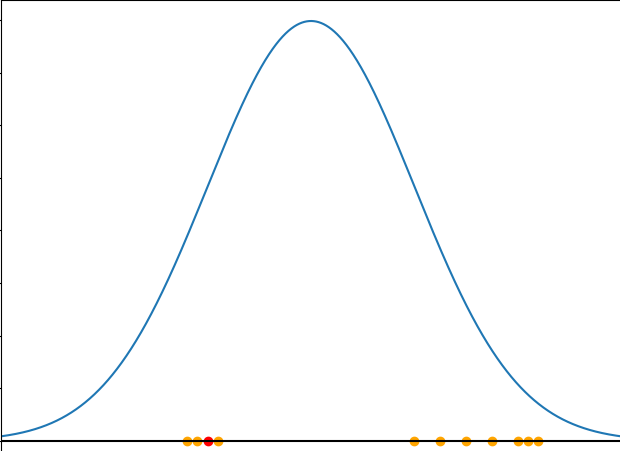

In [16]:
Image(filename="./sacExplication1.png")

L'image ci-dessus illustre notre propos, le point rouge représente l'action optimale dans un état hypothétique dont la loi normale serait celle ci. Les points oranges sont des bonnes actions. La loi normale convergerait donc vers un état similaire à celui-ci. Toutefois, on voit bien qu'elle est assez mal centrée et qu'une bonne partie de son aire se trouve au dessus d'une zone ne contenant aucune bonne action.


La première amélioration à laquelle nous avons pensé est la suivante : Au lieu de n'utiliser qu'une gaussienne simple, nous allons utiliser une mixture de gaussienne. En effet, avec une mixture de gaussienne nous pourrions créer des "bosses" au dessus des différentes zones de bonnes actions et ainsi minimiser l'aire au dessus des zones sans bonnes actions.

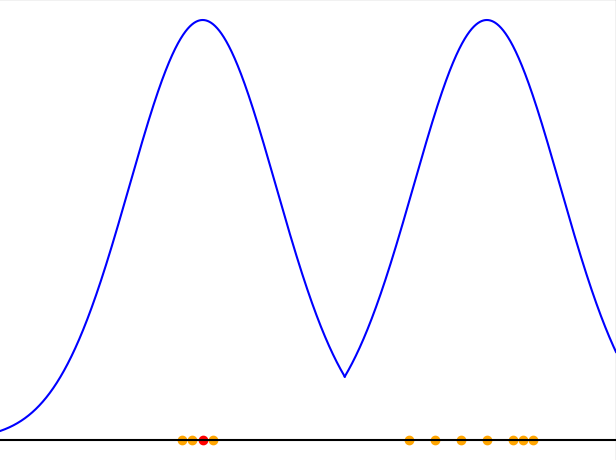

In [17]:
Image(filename="./sacExplication2.png")

On voit dans cette image très clairement que l'aire au dessus de la zone vide est très réduit tandis que l'aire au dessus des 2 zones d'intérêt a drastiquement changé. À ce moment de la refléxion, nous somme bien entendus conscients qu'il y a un monde entre nos idées et la pratique mais nous sommes bien décidés à mettre à l'épreuve notre agent.


Voyons maintenant le code mais aussi et surtout les résultats de ce nouvel agent.

In [3]:
from machin.frame.algorithms import SAC
from machin.utils.logging import default_logger as logger
import torch.nn as nn
env = gym.make("Pendulum-v0")
observe_dim = 3
action_dim = 1
action_range = 2
max_episodes = 500
max_steps = 200
noise_param = (0, 0.2)
noise_mode = "normal"
solved_reward = -140
solved_repeat = 3

In [4]:
# model definition
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_range):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 320)
        self.fc1 = nn.Linear(state_dim, 320)
        self.fc2 = nn.Linear(320, 640)
        self.mu_head = nn.Linear(640, action_dim)
        self.sigma_head = nn.Linear(640, action_dim)
        self.action_range = action_range

    @torch.jit.unused
    def forward(self, state, action=None):
        a = t.relu(self.fc1(state))
        a = t.relu(self.fc2(a))
        mu = self.mu_head(a)
        sigma = softplus(self.sigma_head(a))
        dist = Normal(mu, sigma)
        act = (atanh(action / self.action_range)
               if action is not None
               else dist.rsample())
        act_entropy = dist.entropy()
        # the suggested way to confine your actions within a valid range
        # is not clamping, but remapping the distribution
        act_log_prob = dist.log_prob(act)
        act_tanh = t.tanh(act)
        act = act_tanh * self.action_range
        # the distribution remapping process used in the original essay.
        act_log_prob -= t.log(self.action_range *
                              (1 - act_tanh.pow(2)) +
                              1e-6)
        act_log_prob = act_log_prob.sum(1, keepdim=True)
        return act, act_log_prob, act_entropy

    @torch.jit.export
    def select_action(self, state: List[float], deterministic: bool=False) -> List[float]:
        """
        Compute an action or vector of actions given a state or vector of states
        :param state: the input state(s)
        :param deterministic: whether the policy should be considered deterministic or not
        :return: the resulting action(s)
        """
        state = torch.tensor(state)
        action = self.forward(state)
        #action = np.clip(action,-1,1)
        act: List[float] = action[0].data.tolist()
        return act

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim + action_dim, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, state, action):
        state_action = t.cat([state, action], 1)
        q = t.relu(self.fc1(state_action))
        q = t.relu(self.fc2(q))
        q = self.fc3(q)
        return q

In [5]:
actor = Actor(observe_dim, action_dim, action_range)
critic = Critic(observe_dim, action_dim)
critic_t = Critic(observe_dim, action_dim)
critic2 = Critic(observe_dim, action_dim)
critic2_t = Critic(observe_dim, action_dim)

sac = SAC(actor, critic, critic_t, critic2, critic2_t,
          t.optim.Adam,
          nn.MSELoss(reduction='sum'),visualize=True)

episode, step, reward_fulfilled = 0, 0, 0
smoothed_total_reward = 0
D = {
}
while episode < max_episodes:
    episode += 1
    total_reward = 0
    terminal = False
    step = 0
    state = t.tensor(env.reset(), dtype=t.float32).view(1, observe_dim)

    while not terminal and step <= max_steps:
        step += 1
        with t.no_grad():
            old_state = state
            # agent model inference
            action = sac.act({"state": old_state})[0]
            state, reward, terminal, _ = env.step(action.numpy())
            state = t.tensor(state, dtype=t.float32).view(1, observe_dim)
            total_reward += reward[0]
            sac.store_transition({
                "state": {"state": old_state},
                "action": {"action": action},
                "next_state": {"state": state},
                "reward": reward[0],
                "terminal": terminal or step == max_steps
            })

    # update, update more if episode is longer, else less
    if episode > 100:
        for _ in range(step):
            actor_loss, critic_loss = sac.update()
            D["actor_loss"] = D.get("actor_loss",[]) + [-actor_loss]
            D["critic_loss"] = D.get("critic_loss",[]) + [-critic_loss]
        logger.info("Episode {} actor loss={:.2f} critic loss={:.2f} ".format(episode, actor_loss,critic_loss))
    # show reward
    smoothed_total_reward = (smoothed_total_reward * 0.9 +
                             total_reward * 0.1)
    logger.info("Episode {} total reward={:.2f}"
                .format(episode, smoothed_total_reward))
    if smoothed_total_reward > solved_reward and episode > 100:
        reward_fulfilled = reward_fulfilled + 1
        if reward_fulfilled >= solved_repeat:
            logger.info("Environment solved!")
            break
    else:
        reward_fulfilled = 0

[2020-11-26 14:08:07,317] <WARNING>:default_logger:You have not specified the i/o device of your model <class '__main__.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2020-11-26 14:08:07,593] <INFO>:default_logger:Episode 1 total reward=-112.31
[2020-11-26 14:08:07,875] <INFO>:default_logger:Episode 2 total reward=-247.19
[2020-11-26 14:08:08,175] <INFO>:default_logger:Episode 3 total reward=-351.31
[2020-11-26 14:08:08,554] <INFO>:default_logger:Episode 4 total reward=-467.04
[2020-11-26 14:08:08,944] <INFO>:default_logger:Episode 5 total reward=-552.64
[2020-11-26 14:08:09,298] <INFO>:default_logger:Episode 6 total reward=-679.82
[2020-11-26 14:08:09,577] <INFO>:default_logger:Episode 7 total reward=-752.42
[2020-11-26 14:08:09,930] <INFO>:default_logger:Episode 8 total reward=-817.84
[2020-11-26 14:08:10,207] <INFO>:default_logger:Episode 9 total reward=-886.40
[2020-11-26 14:08:10,494] 

[2020-11-26 14:08:36,174] <INFO>:default_logger:Episode 90 total reward=-1361.22
[2020-11-26 14:08:36,510] <INFO>:default_logger:Episode 91 total reward=-1406.51
[2020-11-26 14:08:36,836] <INFO>:default_logger:Episode 92 total reward=-1427.11
[2020-11-26 14:08:37,195] <INFO>:default_logger:Episode 93 total reward=-1403.15
[2020-11-26 14:08:37,528] <INFO>:default_logger:Episode 94 total reward=-1414.50
[2020-11-26 14:08:37,849] <INFO>:default_logger:Episode 95 total reward=-1405.41
[2020-11-26 14:08:38,167] <INFO>:default_logger:Episode 96 total reward=-1368.89
[2020-11-26 14:08:38,501] <INFO>:default_logger:Episode 97 total reward=-1390.67
[2020-11-26 14:08:38,875] <INFO>:default_logger:Episode 98 total reward=-1329.42
[2020-11-26 14:08:39,237] <INFO>:default_logger:Episode 99 total reward=-1363.35
[2020-11-26 14:08:39,532] <INFO>:default_logger:Episode 100 total reward=-1367.48
[2020-11-26 14:08:39,855] <WARNING>:default_logger:You have not specified the i/o device of your model <clas

[2020-11-26 14:11:01,887] <INFO>:default_logger:Episode 132 actor loss=-129.61 critic loss=21021.86 
[2020-11-26 14:11:01,889] <INFO>:default_logger:Episode 132 total reward=-1223.13
[2020-11-26 14:11:07,621] <INFO>:default_logger:Episode 133 actor loss=-131.49 critic loss=21636.54 
[2020-11-26 14:11:07,622] <INFO>:default_logger:Episode 133 total reward=-1233.65
[2020-11-26 14:11:12,387] <INFO>:default_logger:Episode 134 actor loss=-136.60 critic loss=26326.42 
[2020-11-26 14:11:12,388] <INFO>:default_logger:Episode 134 total reward=-1246.68
[2020-11-26 14:11:17,178] <INFO>:default_logger:Episode 135 actor loss=-142.83 critic loss=27716.90 
[2020-11-26 14:11:17,179] <INFO>:default_logger:Episode 135 total reward=-1239.96
[2020-11-26 14:11:22,619] <INFO>:default_logger:Episode 136 actor loss=-147.40 critic loss=958.79 
[2020-11-26 14:11:22,620] <INFO>:default_logger:Episode 136 total reward=-1237.88
[2020-11-26 14:11:27,810] <INFO>:default_logger:Episode 137 actor loss=-146.14 critic l

[2020-11-26 14:14:23,361] <INFO>:default_logger:Episode 173 total reward=-580.73
[2020-11-26 14:14:28,041] <INFO>:default_logger:Episode 174 actor loss=-234.77 critic loss=1387.04 
[2020-11-26 14:14:28,042] <INFO>:default_logger:Episode 174 total reward=-535.52
[2020-11-26 14:14:33,383] <INFO>:default_logger:Episode 175 actor loss=-235.82 critic loss=40361.01 
[2020-11-26 14:14:33,386] <INFO>:default_logger:Episode 175 total reward=-506.33
[2020-11-26 14:14:38,797] <INFO>:default_logger:Episode 176 actor loss=-242.86 critic loss=35343.83 
[2020-11-26 14:14:38,798] <INFO>:default_logger:Episode 176 total reward=-468.16
[2020-11-26 14:14:43,781] <INFO>:default_logger:Episode 177 actor loss=-236.38 critic loss=1949.79 
[2020-11-26 14:14:43,783] <INFO>:default_logger:Episode 177 total reward=-498.19
[2020-11-26 14:14:49,183] <INFO>:default_logger:Episode 178 actor loss=-236.29 critic loss=1054.89 
[2020-11-26 14:14:49,184] <INFO>:default_logger:Episode 178 total reward=-461.06
[2020-11-26 

[2020-11-26 14:17:43,700] <INFO>:default_logger:Episode 215 actor loss=-257.96 critic loss=1768.08 
[2020-11-26 14:17:43,701] <INFO>:default_logger:Episode 215 total reward=-237.14
[2020-11-26 14:17:48,364] <INFO>:default_logger:Episode 216 actor loss=-250.35 critic loss=1547.42 
[2020-11-26 14:17:48,365] <INFO>:default_logger:Episode 216 total reward=-213.57
[2020-11-26 14:17:52,744] <INFO>:default_logger:Episode 217 actor loss=-259.83 critic loss=1757.20 
[2020-11-26 14:17:52,745] <INFO>:default_logger:Episode 217 total reward=-204.80
[2020-11-26 14:17:57,663] <INFO>:default_logger:Episode 218 actor loss=-243.91 critic loss=2503.21 
[2020-11-26 14:17:57,664] <INFO>:default_logger:Episode 218 total reward=-196.86
[2020-11-26 14:18:02,329] <INFO>:default_logger:Episode 219 actor loss=-247.94 critic loss=115973.18 
[2020-11-26 14:18:02,330] <INFO>:default_logger:Episode 219 total reward=-177.40
[2020-11-26 14:18:07,670] <INFO>:default_logger:Episode 220 actor loss=-269.55 critic loss=17

[2020-11-26 14:20:45,409] <INFO>:default_logger:Episode 256 total reward=-188.49
[2020-11-26 14:20:50,090] <INFO>:default_logger:Episode 257 actor loss=-226.32 critic loss=134285.34 
[2020-11-26 14:20:50,091] <INFO>:default_logger:Episode 257 total reward=-194.13
[2020-11-26 14:20:54,871] <INFO>:default_logger:Episode 258 actor loss=-224.58 critic loss=5997.85 
[2020-11-26 14:20:54,872] <INFO>:default_logger:Episode 258 total reward=-187.12
[2020-11-26 14:20:59,529] <INFO>:default_logger:Episode 259 actor loss=-242.13 critic loss=143757.88 
[2020-11-26 14:20:59,531] <INFO>:default_logger:Episode 259 total reward=-192.50
[2020-11-26 14:21:04,522] <INFO>:default_logger:Episode 260 actor loss=-225.60 critic loss=3853.30 
[2020-11-26 14:21:04,523] <INFO>:default_logger:Episode 260 total reward=-198.66
[2020-11-26 14:21:09,139] <INFO>:default_logger:Episode 261 actor loss=-236.04 critic loss=53357.84 
[2020-11-26 14:21:09,140] <INFO>:default_logger:Episode 261 total reward=-191.38
[2020-11-

[2020-11-26 14:24:16,055] <INFO>:default_logger:Episode 298 actor loss=-198.29 critic loss=174402.34 
[2020-11-26 14:24:16,056] <INFO>:default_logger:Episode 298 total reward=-163.85
[2020-11-26 14:24:21,107] <INFO>:default_logger:Episode 299 actor loss=-167.71 critic loss=5618.52 
[2020-11-26 14:24:21,108] <INFO>:default_logger:Episode 299 total reward=-159.59
[2020-11-26 14:24:26,825] <INFO>:default_logger:Episode 300 actor loss=-193.01 critic loss=225637.97 
[2020-11-26 14:24:26,827] <INFO>:default_logger:Episode 300 total reward=-156.01
[2020-11-26 14:24:32,761] <INFO>:default_logger:Episode 301 actor loss=-165.46 critic loss=5829.01 
[2020-11-26 14:24:32,763] <INFO>:default_logger:Episode 301 total reward=-140.51
[2020-11-26 14:24:39,050] <INFO>:default_logger:Episode 302 actor loss=-178.12 critic loss=6882.93 
[2020-11-26 14:24:39,053] <INFO>:default_logger:Episode 302 total reward=-126.59
[2020-11-26 14:24:45,915] <INFO>:default_logger:Episode 303 actor loss=-179.88 critic loss=

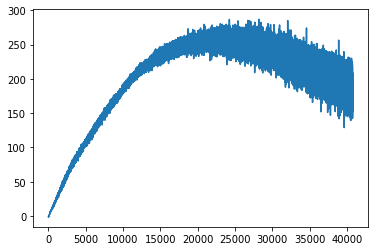

In [6]:
plt.plot(range(len(D["actor_loss"])),D["actor_loss"])

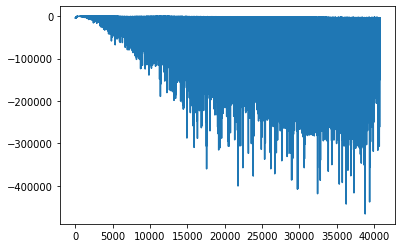

In [7]:
plt.plot(range(len(D["critic_loss"])),D["critic_loss"])

In [8]:
plt.plot(range(len(D["reward_sum"])),D["reward_sum"])

KeyError: 'reward_sum'